# Music Annotation Project: Data Wrangling

## Part 1: Spotify Data Extraction

The first part of this notebook demonstrates the process of data wrangling for a project that will utilize Spotify track metadata and Spotify-generated audio features. The goal is to use metadata from pre-downloaded MP3 files to search for corresponding Spotify tracks, and retrieve their metadata and audio features from Spotify's API. The resulting data will be stored in a DataFrame for further analysis.

### 1) Load Required Libraries

In [1]:
import os
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
from mutagen.mp3 import MP3
from mutagen.easyid3 import EasyID3
from tqdm import tqdm
from glob import glob

### 2) Load and Initialize Spotify Credentials

The Spotify client is initialized with credentials stored in a JSON file. These credentials include the `client_id` and `client_secret` necessary for accessing the Spotify Web API. The `SpotifyClientCredentials` manager handles the OAuth 2.0 flow for server-to-server authentication.

Using any text editor, create a new text file containing the following information. Save the text file as "spotify_credentials.json" and place in '../data/reference' folder. 

```
{
  "client_id":"REPLACE WITH CLIENT ID",
  "client_secret":"REPLACE WITH SECRET",
  "user_id":"REPLACE WITH SPOTIFY USERNAME"
}
```
* Retrieve your client ID and secret here: https://developer.spotify.com/dashboard/
* Retrieve your username here: https://www.spotify.com/us/account/overview/

In [2]:
# Load Spotify credentials
credentials_path = r'../data/reference/spotify_credentials.json' # Path to your spotify_credentials.json file

with open(credentials_path, 'r') as file:
    creds = json.load(file)

# Initialize Spotify client
auth_manager = SpotifyClientCredentials(client_id=creds['client_id'], client_secret=creds['client_secret'])

sp = spotipy.Spotify(auth_manager=auth_manager)

### 3) Parse MP3 Metadata to get track and artist names

In [3]:
def parse_mp3_metadata(file_path):
    """
    Reads MP3 metadata from a given file path.

    This function extracts the track's title and artist(s) from an MP3 file's metadata.
    It handles multiple artists separated by commas or slashes and cleans up the title
    by removing any '(feat.)' annotations.

    Parameters:
    - file_path (str): The file path of the MP3 file to read metadata from.

    Returns:
    - tuple: A tuple containing the track's title and a list of artist names.
             If an error occurs, it returns None for the track title and an empty list for artists.
    """
    try:
        audiofile = MP3(file_path, ID3=EasyID3)
        track_title = audiofile.get('title', [None])[0]
        artist_string = audiofile.get('artist', [None])[0]
        
        # Split artists by comma and then by slash
        artists = []
        if artist_string:
            artist_parts = artist_string.split(',')
            for part in artist_parts:
                artists.extend(part.split('/'))
        
        # Remove any leading and trailing spaces from artist names
        artists = [artist.strip() for artist in artists]
        
        # Clean up the track title
        track_title = track_title.split(' (feat.')[0].strip() if track_title else None
        
        return track_title, artists
    except Exception as e:
        print(f"Error reading metadata for {file_path}: {e}")
        return None, []

### 4) Extract Spotify Track Metadata and Audio Features
Interestingly, Spotify only has 'genre' data for artists and not specific songs.

In [4]:
def extract_spotify_metadata_features(track_title, artists, sp):
    """
    Extracts Spotify metadata and audio features for a given track title and list of artists.

    This function performs a search on Spotify for the track using the provided title and artist names.
    If a match is found, it retrieves the track's ID, artist IDs, genres, and audio features.
    The results are returned in a pandas DataFrame.

    Parameters:
    - track_title (str): The title of the track to search for.
    - artists (list): A list of artist names associated with the track.
    - sp (Spotify client): An authenticated instance of the Spotify client to perform API calls.

    Returns:
    - DataFrame: A pandas DataFrame containing the Spotify metadata and audio features for the track.
                 If no match is found, an empty DataFrame with the specified columns is returned.
    """

    unique_genres = set()  # Use a set to automatically discard duplicates
    track_id, artist_ids = None, None

    # Search for track ID, artist IDs, and genres
    for artist in artists:
        # Format the search query
        query = f"track:{track_title} artist:{artist.strip()}"

        # Search for tracks
        track_results = sp.search(q=query, type='track', limit=1)
        if track_results['tracks']['items']:
            track_item = track_results['tracks']['items'][0]
            track_id = track_item['id']
            artist_ids = [artist['id'] for artist in track_item['artists']]

            # Get genres from the track's artists
            for artist_id in artist_ids:
                artist_genre = sp.artist(artist_id)['genres']
                unique_genres.update(artist_genre)

            # Since we found the track, we don't need to continue searching
            break

    # Retrieve audio features if a match was found
    if track_id and artist_ids:
        # Create a DataFrame from the audio features dictionary
        audio_features_df = pd.DataFrame([sp.audio_features(track_id)[0]])

        # Add track_id, artist_ids, and genre_list as additional columns
        audio_features_df['track_id'] = track_id
        audio_features_df['artist_ids'] = [artist_ids]  # Enclose in a list to ensure it's treated as a single column value
        audio_features_df['genre_list'] = [list(unique_genres)]  # Enclose in a list to ensure it's treated as a single column value

        # Drop specified columns from the DataFrame
        columns_to_drop = ['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms']
        audio_features_df.drop(columns=columns_to_drop, inplace=True)
    else:
        # If no match was found, create an empty DataFrame
        audio_features_df = pd.DataFrame()

    return audio_features_df

### 5) Define the Main Processing Loop

In [5]:
def main_spotify(sp, directory):
    """
    Processes MP3 files in a given directory, extracting metadata, searching for Spotify track and artist IDs and genres,
    and retrieving audio features to generate a comprehensive DataFrame.

    Parameters:
    - sp (SpotifyClientCredentials): An authenticated instance of the Spotify client to perform API calls.
    - directory (str): The directory path containing MP3 files to be processed.

    Returns:
    - DataFrame: A pandas DataFrame containing Spotify audio features and metadata for all processed MP3 files.
    """

    # Initialize an empty DataFrame to store all tracks' info
    all_tracks_df = pd.DataFrame()

    # Get a list of all MP3 files in the directory
    mp3_files = glob(os.path.join(directory, '*.mp3'))

    # Start processing each MP3 file
    for index, file_path in enumerate(mp3_files, start=1):
        print(f"Processing file {index} of {len(mp3_files)}: {os.path.basename(file_path)}")

        # Parse MP3 metadata
        track_title, artists = parse_mp3_metadata(file_path)

        # Continue only if metadata was successfully parsed
        if track_title and artists:
            # Extract Spotify metadata and audio features
            audio_features_df = extract_spotify_metadata_features(track_title, artists, sp)

            # Continue only if audio features were successfully retrieved
            if not audio_features_df.empty:
                # Add track_name, artist_names, and filename columns
                audio_features_df['track_name'] = track_title
                audio_features_df['artist_names'] = ', '.join(artists)
                audio_features_df['filename'] = os.path.basename(file_path)

                # Append this track's DataFrame to the main DataFrame
                all_tracks_df = pd.concat([all_tracks_df, audio_features_df], ignore_index=True)

    return all_tracks_df

### 6) Run Main Loop and Save DataFrame

In [ ]:
directory = r'../data/audio_files/raw_download' # Directory of MP3 files
tracks_df = main_spotify(sp, directory)
tracks_df.to_csv(r'../data/dataframes/spotify_metadata.csv', index=False)

In [6]:
# Resulting DataFrame
pd.read_csv(r'../data/dataframes/spotify_metadata.csv').head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_id,artist_ids,genre_list,track_name,artist_names,filename
0,0.784,0.521,1,-5.701,1,0.0322,0.06200,0.000005,0.0995,0.817,101.491,4,5q3LwAHTqo9d3rET2EA9Nq,"['1AhjOkOLkbHUfcHDSErXQs', '6UbmqUEgjLA6jAcXwb...","['k-pop', 'korean r&b', 'asian american hip hop']",The Weekend,"88rising, BIBI","88rising, BIBI - The Weekend.mp3"
1,0.905,0.838,6,-6.838,1,0.0499,0.00112,0.839000,0.6080,0.464,126.007,4,0oUTyBEY3NQzmu2VuoKpSH,['6EqFMCnVGBRNmwPlk2f3Uc'],"['fidget house', 'brostep', 'electro house', '...",Bass Inside,AC Slater,AC Slater - Bass Inside.mp3
2,0.897,0.692,11,-4.985,0,0.0492,0.01870,0.725000,0.0603,0.607,125.023,4,26xlCgHpcF4GE0FFVsS6Oy,"['6EqFMCnVGBRNmwPlk2f3Uc', '7tm9Tuc70geXOOyKht...","['fidget house', 'house', 'tech house', 'bass ...",Fly Kicks - Wax Motif Remix,"AC Slater, Chris Lorenzo, Wax Motif","AC Slater, Chris Lorenzo - Fly Kicks - Wax Mot..."
3,0.724,0.792,1,-3.332,0,0.1020,0.01140,0.000008,0.6250,0.559,109.997,4,2PAr2vrUwJs6QqRxDv0mP8,"['1NfT4THLhxNASM4xVImfNg', '4pnrk5QCXeKifcD98S...","['kawaii future bass', 'kawaii edm', 'future b...",Space Girl,"AIKA, TOFIE","AIKA, TOFIE - Space Girl.mp3"
4,0.710,0.729,2,-4.978,1,0.0539,0.07430,0.000004,0.0419,0.532,124.995,4,38TlYe1miTAL6r1FyJj7PS,"['4AVFqumd2ogHFlRbKIjp1t', '0awl5piYwO0CDTHEkC...","['progressive electro house', 'pop', 'dutch ho...",I Wanna Know - Alesso & Deniz Koyu Remix,"Alesso, Nico & Vinz, Deniz Koyu","Alesso, Nico & Vinz - I Wanna Know - Alesso & ..."


## Part 2: Audio Segmentation, Audio Feature Generation, and Data Cleaning
In this part of the notebook, we will perform audio segmentation and further clean the data to prepare it for labeling. 
* We will segment the audio files into multiple segments using a change point detection algorithm. Specifically, we will use the KernelCPD algorithm from the ruptures library to identify 3 change points in the tempogram of each audio file. These change points will be the start and end-times of our audio segments.
* A new DataFrame will be created to store the combined segments along with additional extracted information such as key, tempo, and camelot key. The DataFrame will be melted to long format to create a separate row for each segment.
* The audio files will be cut into their segments and exported as MP3 files and organized into a directory.

### 1) Load Required Libraries

In [15]:
# Import necessary libraries
import os
import pandas as pd
import librosa
import numpy as np
import ruptures as rpt
from scipy.signal import argrelextrema
import soundfile as sf
from IPython.display import Image

### 2) Define Functions for Segmentation and Audio Feature Extraction

#### Tempogram: 
A tempogram is a 2D array where the rows represent time and the columns represent frequency. The values in the array represent the strength of the tempo at each time and frequency. It is created by computing the tempo (beats per minute) of the music at regular intervals, typically every 10-50 milliseconds. Tempograms can be plotted on a graph, with time on the x-axis and tempo on the y-axis.

#### Onset envelope:
The onset envelope is a representation of the attack portion of a sound. It is a smoothed version of the absolute value of the waveform. The onset envelope can be used to detect the beginning of notes or other musical events in an audio signal. An onset envelope is represented as a numpy array and used to generate a tempogram. 

In [11]:
# Define a function to compute the tempogram
def compute_tempogram(onset_env, sr, hop_length):
    """
    Computes the tempogram of an audio signal. 

    Parameters:
    - onset_env (ndarray): The onset envelope of the audio signal.
    - sr (int): The sampling rate of the audio signal.
    - hop_length (int): The hop length used to compute the onset envelope.

    Returns:
    - ndarray: The tempogram of the audio signal.
    """
    return librosa.feature.tempogram(onset_envelope=onset_env, sr=sr, hop_length=hop_length)

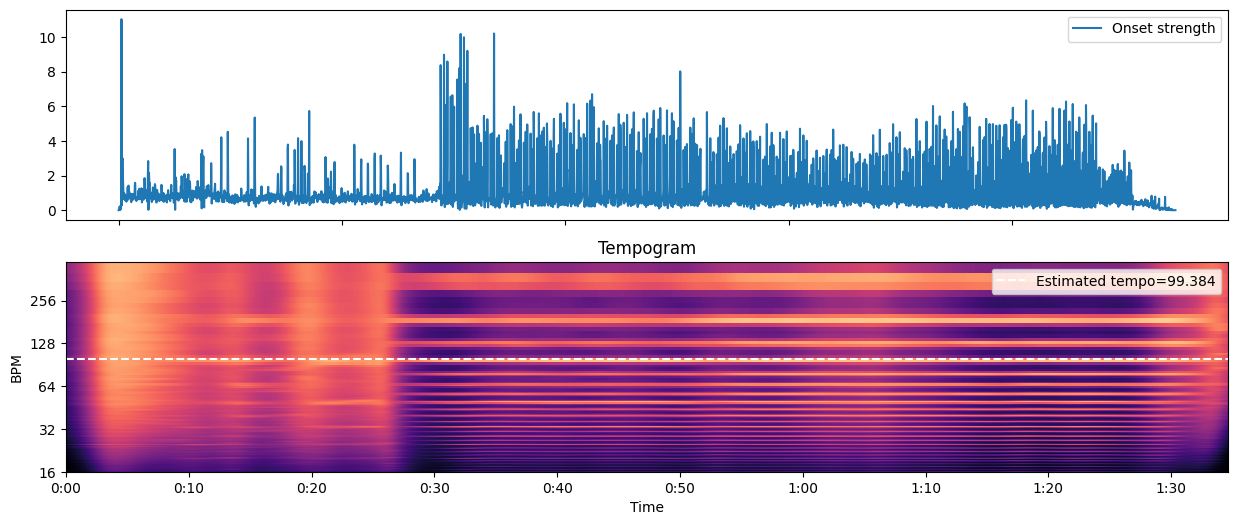

In [19]:
# Here is an example an onset envelope and tempogram visualization of a song:
Image(filename="../figures/tempogram.png")

### Chromagram:
A chromagram is a representation of the pitch content of an audio signal. It is a 12-bin histogram that shows the amount of energy in each of the 12 pitch classes (C, C#, D, ..., B). Chromagrams are often used for music analysis tasks such as key estimation, chord recognition, and melody extraction. 

In [12]:
# Define a function to compute the chromagram
def compute_chromagram(y_harmonic, sr, hop_length):
    """
    Computes the chromagram of an audio signal.

    Parameters:
    - y_harmonic (ndarray): The harmonic component of the audio signal.
    - sr (int): The sampling rate of the audio signal.
    - hop_length (int): The hop length used to compute the chromagram.

    Returns:
    - ndarray: The chromagram of the audio signal.
    """
    return librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, hop_length=hop_length, bins_per_octave=24)

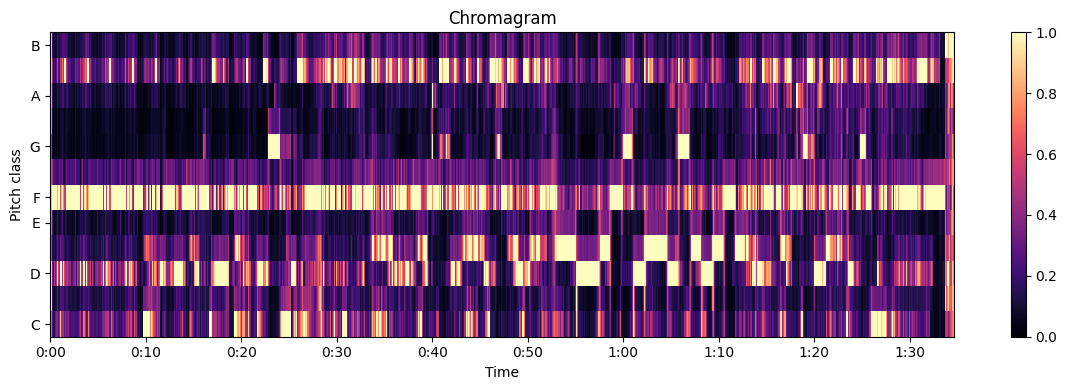

In [18]:
# Here is an example a chromagram visualization of a song:
Image(filename="../figures/chromagram.png")

#### Key/Pitch Detection:
The algorithm used to generate the pitch profiles in the detect_key_from_chromagram function is called *Krumhansl-Schmuckler key-finding algorithm*. This algorithm uses a set of predefined pitch profiles to estimate the key of a piece of music.

The pitch profiles are based on the idea that the notes in a key are more likely to occur together than notes from other keys. The Krumhansl-Schmuckler algorithm uses two sets of pitch profiles, one for major keys and one for minor keys.

#### Camelot Key:
Camelot key is an alternative system for representing musical keys in a way that is easy to understand and visualize. Camelot keys are represented using a number and a letter. The number represents the pitch class of the tonic (root note) of the key, and the letter represents the mode (major or minor).

In [13]:
# Define a function to detect the key of an audio signal
def detect_key_from_chromagram(chromagram, sr):
    """
    Detects the key of an audio signal using the chromagram.

    Parameters:
    - chromagram (ndarray): The chromagram of the audio signal.
    - sr (int): The sampling rate of the audio signal.

    Returns:
    - tuple: A tuple containing the detected key and the key correlation.
    """
    pitches = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    chroma_vals = np.sum(chromagram, axis=1)

    maj_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    min_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

    maj_key_corrs = [np.corrcoef(maj_profile, np.roll(chroma_vals, i))[1, 0] for i in range(12)]
    min_key_corrs = [np.corrcoef(min_profile, np.roll(chroma_vals, i))[1, 0] for i in range(12)]

    key_corrs = maj_key_corrs + min_key_corrs
    keys = [p + ' major' for p in pitches] + [p + ' minor' for p in pitches]

    best_idx = np.argmax(key_corrs)
    best_key = keys[best_idx]
    best_corr = key_corrs[best_idx]

    return best_key, best_corr

# Define a function to convert a standard key to a Camelot key
def get_camelot(key):
    """
    Converts a standard key to a Camelot key.

    Parameters:
    - key (str): The standard key of the audio signal.

    Returns:
    - str: The Camelot key of the audio signal.
    """
    camelot_major = {
        'B': '1B', 'F#': '2B', 'C#': '3B', 'G#': '4B', 'D#': '5B',
        'A#': '6B', 'F': '7B', 'C': '8B', 'G': '9B', 'D': '10B', 'A': '11B', 'E': '12B'
    }

    camelot_minor = {
        'G#': '1A', 'D#': '2A', 'A#': '3A', 'F': '4A', 'C': '5A',
        'G': '6A', 'D': '7A', 'A': '8A', 'E': '9A', 'B': '10A', 'F#': '11A', 'C#': '12A'
    }

    pitch, mode = key.split(' ')

    if mode == 'major':
        return camelot_major[pitch]
    elif mode == 'minor':
        return camelot_minor[pitch]
    else:
        raise ValueError("Invalid mode in key: should be 'major' or 'minor'.")

#### Segmentation algorithm
This function segments a waveform with a fixed number of segments using a change point detection algorithm to find the breakpoints in the waveform. The breakpoints are the points where the waveform changes significantly. For this project I decided on a set number of breakpoints, 3. Alternatively, you can find the optimal amount of break points for each individual song but that was too computationally expensive. The tempo or chroma waveforms of a song can be used in this algorithm and it will decide on breakpoints accordingly. 

In [21]:
# Define a function to segment a waveform with n_bkps=3
def segment_waveform_fixed_k(algo, sr, n_bkps=3):
    """
    Segments a waveform with a fixed number of segments.

    Parameters:
    - algo (ruptures.KernelCPD): The change point detection algorithm to use.
    - sr (int): The sampling rate of the audio signal.
    - n_bkps (int): The number of segments to use.

    Returns:
    - list: A list of segment times.
    """
    bkps = algo.predict(n_bkps=n_bkps)
    times = librosa.frames_to_time(bkps[:-1], sr=sr, hop_length=512)
    return times

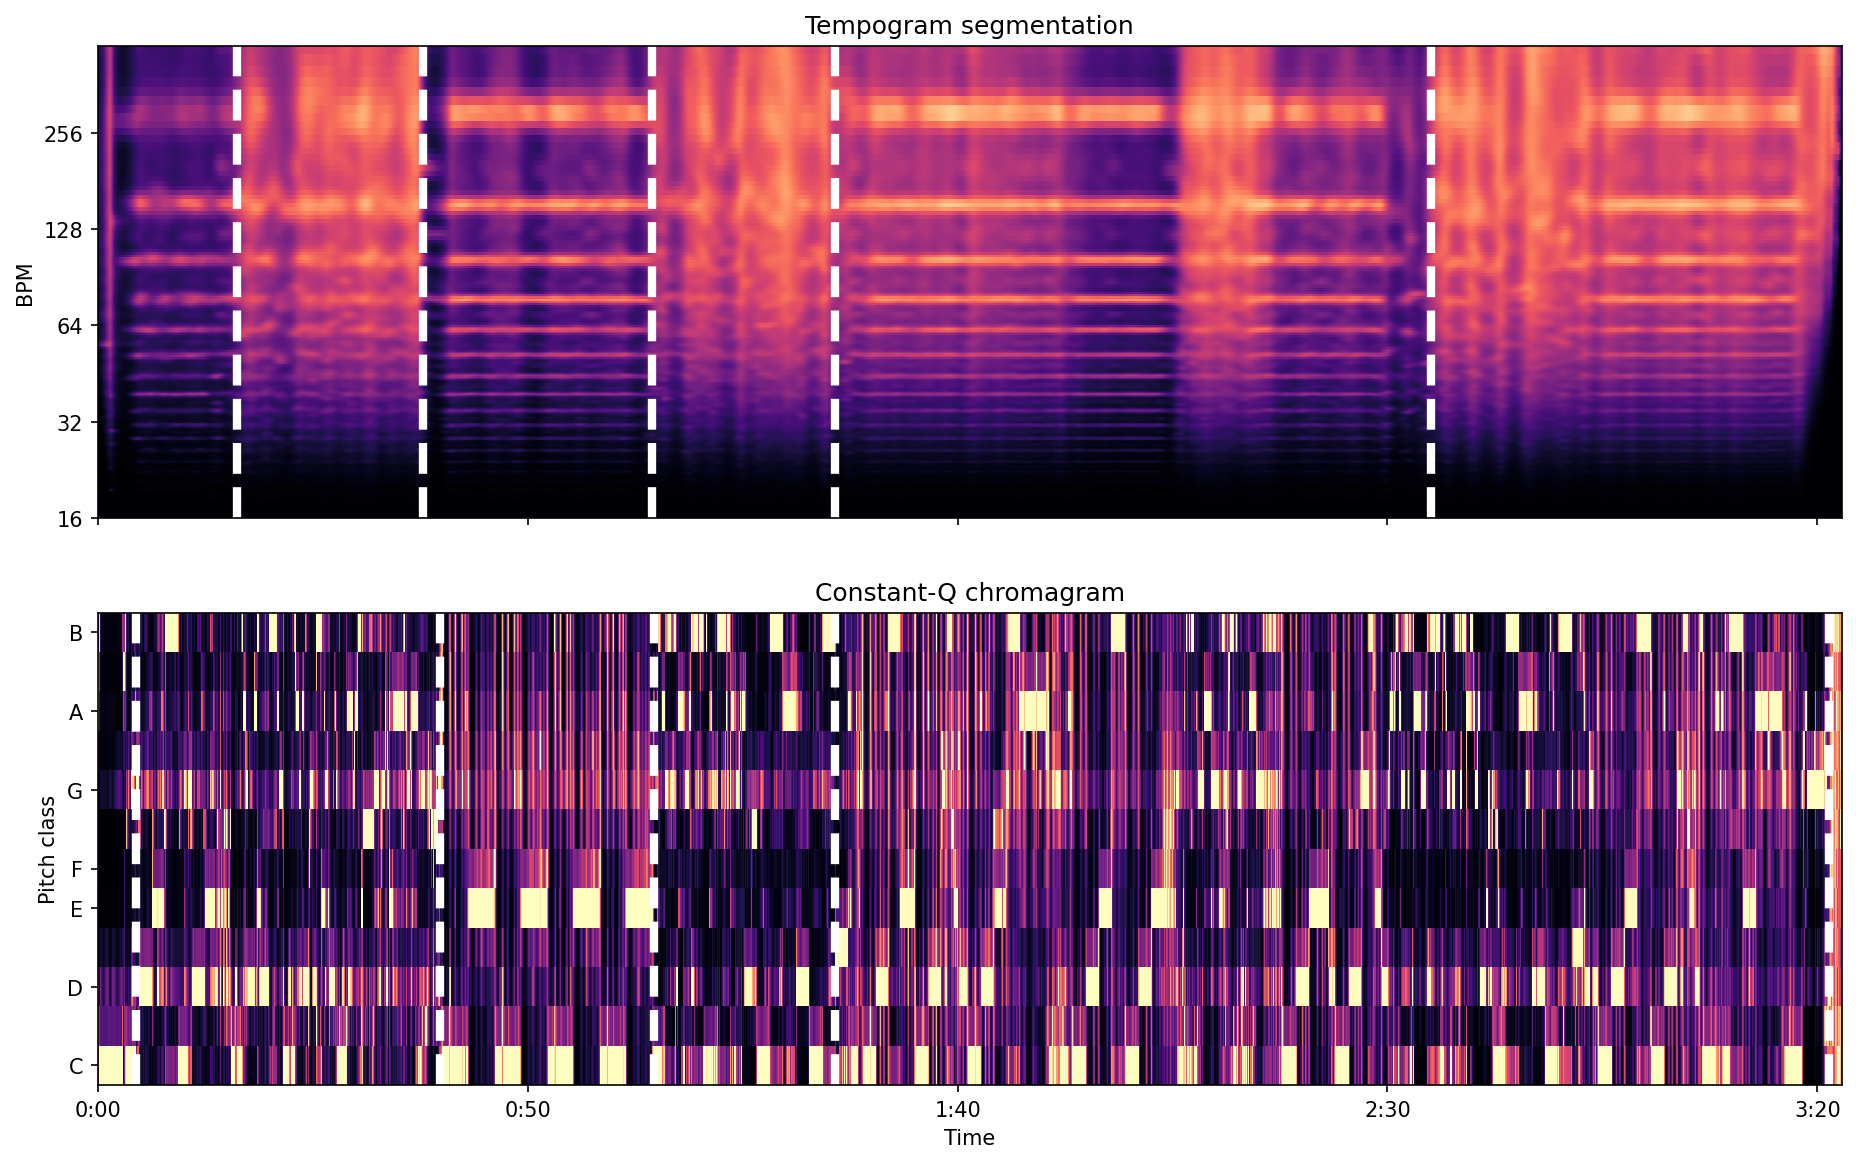

In [20]:
# Here is an example of how segmentation would look like on the tempogram and chromagram waveforms of a song with optimized n_bkps:
Image(filename="../figures/tempochromasegmentation.png")

### 3) Run the segmenting processing loop

In [ ]:
# Main processing loop
# Load the DataFrame from CSV
reference_df = pd.read_csv('../data/dataframes/spotify_metadata.csv')
audio_files_dir = '../data/audio_files/processed_download'
hop_length = 512
new_columns = ['track_name', 'artist_names','duration', 'ks_key', 'key_corr',
               'overall_tempo', 'camelot_key', 'times_tempogram_kfixed','times_chroma_kfixed'] 

# Iterate over the audio files
for index, row in tqdm(reference_df.iterrows(), total=reference_df.shape[0]):
    file_path = os.path.join(audio_files_dir, row['filename'])
    if os.path.isfile(file_path):
        # Load the audio file
        signal, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=signal, sr=sr)

        # Separate the harmonic and percussive components
        y_harmonic, y_percussive = librosa.effects.hpss(signal)

        # Compute onset envelope
        onset_env = librosa.onset.onset_strength(y=y_percussive, sr=sr, hop_length=hop_length)

        # Compute the tempogram and chromagram
        tempogram = compute_tempogram(onset_env, sr, hop_length)
        chromagram = compute_chromagram(y_harmonic, sr, hop_length)

        # Compute the overall key
        key, key_corr = detect_key_from_chromagram(chromagram, sr)
        camelot = get_camelot(key)

        # Compute the overall tempo
        tempo = librosa.feature.tempo(onset_envelope=onset_env, sr=sr)[0]

        # Segment using tempogram with n_bkps=3
        algo_tempogram = rpt.KernelCPD(kernel="linear").fit(tempogram.T)
        k3_segments_tempo = segment_waveform_fixed_k(algo_tempogram, sr=sr, n_bkps=3)

        # Segment using chromagram with n_bkps=3
        algo_chroma = rpt.KernelCPD(kernel="linear").fit(chromagram.T)
        k3_segments_chroma = segment_waveform_fixed_k(algo_chroma, sr=sr, n_bkps=3)

        # Store the results in the DataFrame
        reference_df.at[index, 'duration'] = duration
        reference_df.at[index, 'ks_key'] = str(key)
        reference_df.at[index, 'key_corr'] = float(key_corr)
        reference_df.at[index, 'camelot_key'] = str(camelot)
        reference_df.at[index, 'overall_tempo'] = float(tempo)
        reference_df.at[index, 'times_tempogram_kfixed'] = ','.join(map(str, k3_segments_tempo))
        reference_df.at[index, 'times_chroma_kfixed'] = ','.join(map(str, k3_segments_chroma))

In [27]:
# Resulting dataframe that took 6 hours to process
pd.read_csv(r'../data/dataframes/segment_df.csv')[new_columns]

,track_name,artist_names,duration,ks_key,key_corr,overall_tempo,camelot_key,times_tempogram_kfixed,times_chroma_kfixed
0,The Weekend,"88rising, BIBI",164.771,B major,0.600193,102.272727,1B,"3.6586666666666665,78.22933333333333,127.456","104.576,116.064,163.12533333333334"
1,Bass Inside,AC Slater,259.995,G minor,0.532695,125.000000,6A,"60.757333333333335,120.88533333333334,165.92","31.082666666666668,60.821333333333335,227.2106..."
2,Fly Kicks - Wax Motif Remix,"AC Slater, Chris Lorenzo, Wax Motif",276.425,F# minor,0.489705,125.000000,11A,"43.861333333333334,138.016,154.10133333333334","44.053333333333335,139.92533333333333,183.072"
3,Space Girl,"AIKA, TOFIE",216.506,B minor,0.869059,110.294118,10A,"19.029333333333334,53.06666666666667,141.93066...","19.573333333333334,123.30666666666667,141.7173..."
4,I Wanna Know - Alesso & Deniz Koyu Remix,"Alesso, Nico & Vinz, Deniz Koyu",323.466,A# major,0.576438,125.000000,6B,"29.066666666666666,236.256,292.36266666666666","29.610666666666667,230.29333333333332,260.2346..."
...,...,...,...,...,...,...,...,...,...
348,Done With Love,Zedd,294.722,F minor,0.736818,127.840909,4A,"23.584,25.6,242.08","31.584,207.62666666666667,241.80266666666665"
349,Straight Into The Fire,Zedd,218.284,A major,0.733972,127.840909,11B,"33.44,95.57333333333334,169.90933333333334","18.88,170.02666666666667,205.67466666666667"
350,Candyman,"Zedd, Aloe Blacc",177.839,A# minor,0.742648,100.446429,3A,"15.573333333333334,41.81333333333333,164.85333...","33.034666666666666,161.83466666666666,166.1333..."
351,Clarity,"Zedd, Foxes",266.043,E major,0.770222,127.840909,12B,"37.034666666666666,181.728,211.66933333333333","64.82133333333333,112.96,199.60533333333333"


In [28]:
reference_df = pd.read_csv(r'../data/dataframes/segment_df.csv')

### 4) Data-wrangling

In [35]:
segment_df = reference_df.copy()
prefix_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
               'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
               'time_signature']

segment_df.rename(columns=lambda x: 'sp_' + x if x in prefix_cols else x, inplace=True)

# Splitting and converting 'times_tempogram_kfixed' column to numeric
tempo_split = segment_df['times_tempogram_kfixed'].str.split(',', expand=True)
segment_df['tempo_time_1'] = pd.to_numeric(tempo_split[0], errors='coerce')
segment_df['tempo_time_2'] = pd.to_numeric(tempo_split[1], errors='coerce')
segment_df['tempo_time_3'] = pd.to_numeric(tempo_split[2], errors='coerce')

# Splitting and converting 'times_chroma_kfixed' column to numeric
chroma_split = segment_df['times_chroma_kfixed'].str.split(',', expand=True)
segment_df['chroma_time_1'] = pd.to_numeric(chroma_split[0], errors='coerce')
segment_df['chroma_time_2'] = pd.to_numeric(chroma_split[1], errors='coerce')
segment_df['chroma_time_3'] = pd.to_numeric(chroma_split[2], errors='coerce')

# Dropping the specified columns
segment_df.drop(['times_tempogram_kfixed', 'times_chroma_kfixed',
                 'numseg_combined_kfixed', 'times_combined_kfixed'], axis=1, inplace=True)

# Adding start and end times to each segment before turning it long format
def create_segment_columns(row):
    # Initialize the segment columns with None
    for i in range(4):
        row[f'tempo_seg_{i}'] = None
        row[f'chroma_seg_{i}'] = None

    # Create the tuples for tempo segments
    for i in range(4):
        start_time = 0 if i == 0 else row[f'tempo_time_{i}']
        end_time = row[f'tempo_time_{i+1}'] if i < 3 else row['duration']
        
        # Only create a tuple if start_time and end_time are not null
        if pd.notnull(start_time) and pd.notnull(end_time):
            row[f'tempo_seg_{i}'] = (start_time, end_time)

    # Create the tuples for chroma segments
    for i in range(4):
        start_time = 0 if i == 0 else row[f'chroma_time_{i}']
        end_time = row[f'chroma_time_{i+1}'] if i < 3 else row['duration']
        
        # Only create a tuple if start_time and end_time are not null
        if pd.notnull(start_time) and pd.notnull(end_time):
            row[f'chroma_seg_{i}'] = (start_time, end_time)

    return row

# Apply the function to each row in the DataFrame
segment_df = segment_df.apply(create_segment_columns, axis=1)

# Melt the DataFrame to long format
df_long = segment_df.melt(id_vars=['track_id', 'artist_ids', 'genre_list', 'track_name', 'artist_names',
       'filename', 'duration', 'ks_key', 'key_corr', 'camelot_key'],
       value_vars=['tempo_seg_0', 'tempo_seg_1', 'tempo_seg_2', 'tempo_seg_3',
       'chroma_seg_0', 'chroma_seg_1', 'chroma_seg_2', 'chroma_seg_3'],
       var_name='segment', value_name='value')

# Extract segment type from the 'segment' column
df_long['segment_type'] = df_long['segment'].str.split('_', expand=True)[0]

# Extract segment order from the 'segment' column
df_long['segment_order'] = df_long['segment'].str.split('_', expand=True)[2].astype(int)

# Extract start and end times from the 'value' column
df_long['value'] = df_long['value'].astype(str)
df_long[['start_time', 'end_time']] = df_long['value'].str[1:-1].str.split(',', expand=True).astype(float)

# Drop the original 'segment' and 'value' columns
df_long.drop(columns=['segment', 'value'], inplace=True)

df_long = df_long.sort_values(by=['track_name', 'segment_type', 'segment_order'], ascending=[True, False, True])

# Create empty column for manual labeling
df_long['label'] = np.nan
df_long

,track_id,artist_ids,genre_list,track_name,artist_names,filename,duration,ks_key,key_corr,camelot_key,segment_type,segment_order,start_time,end_time,label
338,28X0E21uKdA7S1HvgMJjP8,['3534yWWzmxx8NbKVoNolsK'],"['progressive electro house', 'house', 'edm', ...",28 Grams,Wolfgang Gartner,Wolfgang Gartner - 28 Grams.mp3,184.329,F# major,0.409054,2B,tempo,0,0.000000,20.256000,NaN
691,28X0E21uKdA7S1HvgMJjP8,['3534yWWzmxx8NbKVoNolsK'],"['progressive electro house', 'house', 'edm', ...",28 Grams,Wolfgang Gartner,Wolfgang Gartner - 28 Grams.mp3,184.329,F# major,0.409054,2B,tempo,1,20.256000,105.845333,NaN
1044,28X0E21uKdA7S1HvgMJjP8,['3534yWWzmxx8NbKVoNolsK'],"['progressive electro house', 'house', 'edm', ...",28 Grams,Wolfgang Gartner,Wolfgang Gartner - 28 Grams.mp3,184.329,F# major,0.409054,2B,tempo,2,105.845333,178.154667,NaN
1397,28X0E21uKdA7S1HvgMJjP8,['3534yWWzmxx8NbKVoNolsK'],"['progressive electro house', 'house', 'edm', ...",28 Grams,Wolfgang Gartner,Wolfgang Gartner - 28 Grams.mp3,184.329,F# major,0.409054,2B,tempo,3,178.154667,184.329000,NaN
1750,28X0E21uKdA7S1HvgMJjP8,['3534yWWzmxx8NbKVoNolsK'],"['progressive electro house', 'house', 'edm', ...",28 Grams,Wolfgang Gartner,Wolfgang Gartner - 28 Grams.mp3,184.329,F# major,0.409054,2B,chroma,0,0.000000,27.978667,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,4JUD1cL0uwd4lJKI9jCgso,['6fs2or0cKLEM2xohWq8SoX'],['chinese electropop'],香芋的错觉 CAROUSEL,Lexie Liu,Lexie Liu - 香芋的错觉 CAROUSEL.mp3,195.530,A# major,0.597794,6B,tempo,3,145.952000,195.530000,NaN
1563,4JUD1cL0uwd4lJKI9jCgso,['6fs2or0cKLEM2xohWq8SoX'],['chinese electropop'],香芋的错觉 CAROUSEL,Lexie Liu,Lexie Liu - 香芋的错觉 CAROUSEL.mp3,195.530,A# major,0.597794,6B,chroma,0,0.000000,16.416000,NaN
1916,4JUD1cL0uwd4lJKI9jCgso,['6fs2or0cKLEM2xohWq8SoX'],['chinese electropop'],香芋的错觉 CAROUSEL,Lexie Liu,Lexie Liu - 香芋的错觉 CAROUSEL.mp3,195.530,A# major,0.597794,6B,chroma,1,16.416000,130.293333,NaN
2269,4JUD1cL0uwd4lJKI9jCgso,['6fs2or0cKLEM2xohWq8SoX'],['chinese electropop'],香芋的错觉 CAROUSEL,Lexie Liu,Lexie Liu - 香芋的错觉 CAROUSEL.mp3,195.530,A# major,0.597794,6B,chroma,2,130.293333,145.738667,NaN


In [ ]:
df_long.to_csv(r'../data/dataframes/segments_long.csv', index=False)